In [253]:
import pandas as pd
import os
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV

## 1. Lectura base de datos

In [254]:
data_path = r"D:\DANE - Contrato\2024\Operativo Barrido\Data"
emicron = pd.read_csv(os.path.join(data_path,"EMICRON_VF.csv"),header = 0)

In [255]:
var_estab = ['id','VENTAS_MES_ANTERIOR','CYG','POTTOT','REMUNERACION_TOTAL','COD_DEPTO','CPAM','GRUPOS4','UBICA','IDRUT','CAMCOMER','REG_CONT','ANIOS_OPERACION'] 

var_mov = ['id','VENTAS_MES_ANTERIOR','POTTOT','CYG','COD_DEPTO','CPAM','GRUPOS4','ANOS_ESPACIO','HOMBRE']

In [256]:
def descriptive_stat_threshold(df, pred_score, threshold, opcion = 1):
    # Observemos cuántos 0 o 1 hay
    if opcion == 1:    
        df = pd.DataFrame(df)
        df['Anomaly_Score'] = pred_score
        df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')
        # Ahora mostraremos las estadísticas resumen
        cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns = {'Anomaly_Score': 'Count'})
        # Conto del conteo
        cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100
        # Promedio
        stat = df.groupby('Group').mean().round(2).reset_index()
        # Poniendo el conteo y el promedio juntos
        stat = cnt.merge(stat, left_on = 'Group', right_on = 'Group')
        return(stat)
    else:
        df = pd.DataFrame(df)
        df['Anomaly_Score'] = pred_score
        df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Outlier', 'Normal')
        return(df)

## 2. Operativo de barrido: establecimientos
Se seleccionarán las unidades económicas de la base de datos que corresponden con viviendas con actividad económica y establecimientos fijos (locales, tienda,  talleres, etc.)  
Por el momento se trabajará únicamente con el año 2022, debido a que la base de 2023 todavía no está completa (hace falta remuneración) 

In [257]:
emicron_estab = emicron[emicron['UBICA']!= 4]
emicron_estab = emicron_estab[emicron_estab['OLA']== 2022]
emicron_estab = emicron_estab[var_estab]
emicron_estab['UBICA'] = emicron_estab['UBICA'].astype(int)
emicron_estab['REG_CONT'] = emicron_estab['REG_CONT'].astype(int)
emicron_estab['IDRUT'] = emicron_estab['IDRUT'].astype(int)
emicron_estab['CAMCOMER'] = emicron_estab['CAMCOMER'].astype(int)
emicron_estab = emicron_estab.reset_index(drop=True)
emicron_estab.shape

(24026, 13)

#### One-hot encoding

In [258]:
emicron_ohe = emicron_estab.copy()

ohe_dpto = OneHotEncoder().fit(emicron_ohe[['COD_DEPTO']])
drop_enc = ohe_dpto.transform(emicron_ohe[['COD_DEPTO']]).toarray()
drop_enc_df = pd.DataFrame(drop_enc,columns = ohe_dpto.get_feature_names_out())


emicron_ohe = emicron_ohe.join(drop_enc_df)

ohe_ubi = OneHotEncoder().fit(emicron_ohe[['UBICA']])
drop_enc = ohe_ubi.transform(emicron_ohe[['UBICA']]).toarray()
drop_enc_df = pd.DataFrame(drop_enc,columns = ohe_ubi.get_feature_names_out())
drop_enc_df.drop('UBICA_3', axis=1, inplace = True)  

emicron_ohe = emicron_ohe.join(drop_enc_df)

ohe_sector = OneHotEncoder().fit(emicron_ohe[['GRUPOS4']])
drop_enc = ohe_sector.transform(emicron_ohe[['GRUPOS4']]).toarray()
drop_enc_df = pd.DataFrame(drop_enc,columns = ohe_sector.get_feature_names_out())

emicron_ohe = emicron_ohe.join(drop_enc_df)

ohe_conta = OneHotEncoder().fit(emicron_ohe[['REG_CONT']])
drop_enc = ohe_conta.transform(emicron_ohe[['REG_CONT']]).toarray()
drop_enc_df = pd.DataFrame(drop_enc,columns = ohe_conta.get_feature_names_out())

emicron_ohe = emicron_ohe.join(drop_enc_df)

In [259]:
emicron_ohe.drop(['COD_DEPTO','UBICA','GRUPOS4','REG_CONT'],axis=1, inplace= True) 
emicron_ohe.set_index('id',inplace = True, drop = True)

In [260]:
emicron_ohe.shape

(24026, 41)

In [261]:
# Parameters
k_sam = [256, 500, 700, 1000]
k_tree = [100,500,1000]

#Almacenar los resultados
iscores_mult = np.zeros([emicron_ohe.shape[0], (len(k_sam)*len(k_tree))])

i = 0

for sam in k_sam:
    for n_tree in k_tree:
        ifo = IsolationForest(random_state = 123,
                              contamination=0.1,
                              max_features= 25,
                              verbose=1,
                              n_jobs=-1,
                              max_samples= sam,
                              n_estimators= n_tree)
        ifo.fit(emicron_ohe)
        # Cálculo del puntaje de atipicidad promedio: valores más bajos representas mayor atipicidad
        iscores_mult[:, i] = ifo.decision_function(emicron_ohe)
        i +=1

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.7s remaining:    5.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.1s remaining:   12.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


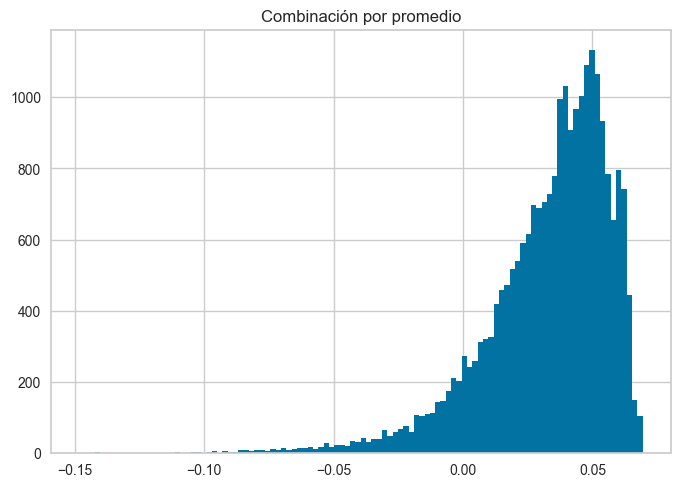

In [262]:
# El promedio de las predicciones de los 10 puntajes están en y_by_average abajo. Se crea esto en un histograma
# El resultado "y_by_average" es una columna:
Y_by_average = np.mean(iscores_mult,axis=1)
plt.hist(Y_by_average, bins = 'auto')
#plt.xlim(4.2, 8)
plt.title("Combinación por promedio")
plt.show()

In [263]:
threshold = np.percentile(Y_by_average, 10)
threshold

0.000599718825754568

In [264]:
iforest_res = descriptive_stat_threshold(emicron_estab, Y_by_average, threshold, 2)

In [265]:
iforest_res['Group'].value_counts()

Normal     21623
Outlier     2403
Name: Group, dtype: int64

In [266]:
iforest_res.to_csv(os.path.join(data_path,"atpcs_iforest_fijo.csv"), index = False)

## 3. Operativo de barrido: vendedores de calles
Se seleccionarán las unidades económicas de la base de datos que corresponden con puestos móviles.

In [267]:
emicron_mov = emicron[emicron['UBICA']== 4]
emicron_mov = emicron_mov[var_mov]
emicron_mov['CPAM'] = emicron_mov['CPAM'].astype(int)
emicron_mov['COD_DEPTO'] = emicron_mov['COD_DEPTO'].astype(int)
emicron_mov['GRUPOS4'] = emicron_mov['GRUPOS4'].astype(int)

emicron_mov = emicron_mov.reset_index(drop=True)
emicron_mov.shape

(17812, 9)

In [268]:
emicron_mov.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17812 entries, 0 to 17811
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   17812 non-null  int64  
 1   VENTAS_MES_ANTERIOR  17812 non-null  float64
 2   POTTOT               17812 non-null  float64
 3   CYG                  17812 non-null  float64
 4   COD_DEPTO            17812 non-null  int32  
 5   CPAM                 17812 non-null  int32  
 6   GRUPOS4              17812 non-null  int32  
 7   ANOS_ESPACIO         17812 non-null  float64
 8   HOMBRE               17812 non-null  float64
dtypes: float64(5), int32(3), int64(1)
memory usage: 1.0 MB


#### One-hot encoding

In [269]:
emicron_ohe = emicron_mov.copy()

ohe_dpto = OneHotEncoder().fit(emicron_ohe[['COD_DEPTO']])
drop_enc = ohe_dpto.transform(emicron_ohe[['COD_DEPTO']]).toarray()
drop_enc_df = pd.DataFrame(drop_enc,columns = ohe_dpto.get_feature_names_out())

emicron_ohe = emicron_ohe.join(drop_enc_df)

ohe_sector = OneHotEncoder().fit(emicron_ohe[['GRUPOS4']])
drop_enc = ohe_sector.transform(emicron_ohe[['GRUPOS4']]).toarray()
drop_enc_df = pd.DataFrame(drop_enc,columns = ohe_sector.get_feature_names_out())

emicron_ohe = emicron_ohe.join(drop_enc_df)

ohe_anio = OneHotEncoder().fit(emicron_ohe[['ANOS_ESPACIO']])
drop_enc = ohe_anio.transform(emicron_ohe[['ANOS_ESPACIO']]).toarray()
drop_enc_df = pd.DataFrame(drop_enc,columns = ohe_anio.get_feature_names_out())

emicron_ohe = emicron_ohe.join(drop_enc_df)

In [270]:
emicron_ohe.drop(['COD_DEPTO','GRUPOS4','ANOS_ESPACIO'],axis=1, inplace= True) 
emicron_ohe.set_index('id',inplace = True, drop = True)

In [271]:
# Parameters
k_sam = [256, 500, 800, 1000]
k_tree = [100,250, 500,1000]

#Almacenar los resultados
iscores_mult = np.zeros([emicron_ohe.shape[0], (len(k_sam)*len(k_tree))])

i = 0

for sam in k_sam:
    for n_tree in k_tree:
        ifo = IsolationForest(random_state = 123,
                              contamination=0.1,
                              max_features= 34,
                              verbose=1,
                              n_jobs=-1,
                              max_samples= sam,
                              n_estimators= n_tree)
        ifo.fit(emicron_ohe)
        iscores_mult[:, i] = ifo.decision_function(emicron_ohe)
        i +=1

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.8s remaining:    2.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.8s remaining:    5.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    3.7s remaining:   11.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


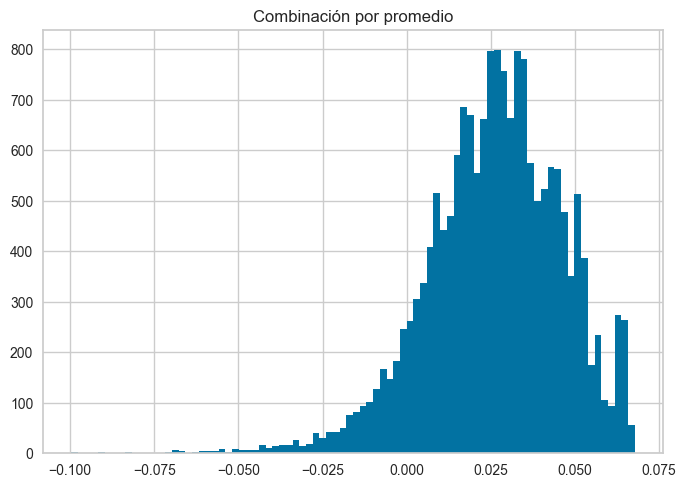

In [272]:
# El promedio de las predicciones de los 10 puntajes están en y_by_average abajo. Se crea esto en un histograma
# El resultado "y_by_average" es una columna:
Y_by_average = np.mean(iscores_mult,axis=1)
plt.hist(Y_by_average, bins = 'auto')
#plt.xlim(4.2, 8)
plt.title("Combinación por promedio")
plt.show()

In [273]:
threshold = np.percentile(Y_by_average, 5)
threshold

-0.008095662975985934

In [274]:
iforest_res = descriptive_stat_threshold(emicron_mov, Y_by_average, threshold, 2)

In [275]:
iforest_res['Group'].value_counts()

Normal     16921
Outlier      891
Name: Group, dtype: int64

In [276]:
iforest_res.to_csv(os.path.join(data_path,"atpcs_iforest_vencalle.csv"), index = False)